##### Colab

In [1]:
# Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import userdata
import os

os.environ["kaggle_key"] = userdata.get('kaggle_key')
os.environ["kaggle_username"] = userdata.get('kaggle_username')

In [4]:
!kaggle datasets download -d ravidussilva/real-ai-art
! unzip "real-ai-art"

Streaming output truncated to the last 5000 lines.
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_114.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_116.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_142.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_154.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_183.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_186.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_201.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_219.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_230.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_274.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_279.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_286.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_3.jpg  
  inflating: Re

##### Local & Colab

In [1]:
#Imports
import sys
#sys.path.append('/Users/viktoriiaovsianik/Documents/Uni/04_WS2024/06_ADL/Code/ADL-WS-2024')
sys.path.append('/content/drive/MyDrive/06_TUWien/10_ADL')
from scripts.run_cnn import train_model, test_model
from scripts.viz import display_images

from datasets.AIArtBench import AIArtbench
from datasets.dataset import Subset
from datasets.preprocessing import CustomDatasetPreprocessor
from torch.utils.data import DataLoader
from models.cnn import CNN_Net
from models.simple_cnn import Simple_CNN
from scripts.evaluation import analyze_test_results
import torchvision.transforms as transforms

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovsvc (ovsvc-tu-wien). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Import dataset & look what's inside

In [2]:
# Define your dataset path
#dataset_path = "/Users/viktoriiaovsianik/Documents/Uni/04_WS2024/06_ADL/Code/ADL-WS-2024/data"
dataset_path = "/content/Real_AI_SD_LD_Dataset"

In [3]:
# Process Data to print some images
preprocessor = CustomDatasetPreprocessor(dataset_path)
preprocessor.preprocess(fraction=0.2)

# Get dataset splits
train_data, validation_data, test_data = preprocessor.get_splits()

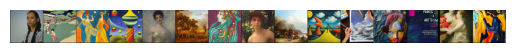

AI_realism AI_ukiyo-e AI_art_nouveau AI_surrealism human_romanticism human_romanticism AI_art_nouveau human_romanticism human_romanticism AI_surrealism AI_realism AI_surrealism AI_expressionism AI_romanticism AI_expressionism


In [4]:
# Print images from train dataset + check how different transformations work

train_transform = transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor()
    ])

# Prepare the training dataset and DataLoader
train_dataset = AIArtbench(dataframe=train_data, subset=Subset.TRAINING, transform=train_transform)
# Extract images
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
# Get unique class names
classes = train_dataset.get_classes()
# Display a few images from the training data
display_images(data_loader=train_data_loader, classes=classes, num_images=15, save_path="train_images_grid.png")

#### Train & test baseline

In [4]:
# Define transformations

train_transform = transforms.Compose([
        transforms.Resize(size=(32, 32)),
        transforms.ToTensor()
    ])

val_transform = transforms.Compose([
        transforms.Resize(size=(32, 32)),
        transforms.ToTensor()
    ])

test_transform = transforms.Compose([
        transforms.Resize(size=(32, 32)),
        transforms.ToTensor()
    ])


# Config for training and testing
config = {
    'model': Simple_CNN(),
    'dataset_path': dataset_path,
    'model_save_dir': 'saved_models',
    'results_save_dir': 'saved_results',
    'train_transform': train_transform,
    'val_transform': val_transform,
    'test_transform': test_transform,
    'batch_size': 64,
    'learning_rate': 0.001,
    'scheduler_gamma': 0.9,
    'epochs': 10,
    'fraction': 1,
    'val_frequency': 2,
    'debug_mode': True,
    'patience': 3,
    'model_name': "Simple_CNN"
}

# Train the model

trainer = train_model(config)

CUDA (GPU) is available.
Preprocessing dataset...
Train dataset length: 90000
Validation dataset length: 10000
Test dataset length: 30000
Model: Simple_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1024, out_features=20, bias=True)
)


Training with batch size: 64
Epoch 0/10:
--- Training epoch 0 ---


Train:   0%|          | 1/1407 [00:00<20:03,  1.17it/s]

Batch 0, Loss: 3.0003890991210938


Train:  36%|███▌      | 501/1407 [02:58<06:29,  2.33it/s]

Batch 500, Loss: 2.92824125289917


Train:  71%|███████   | 1001/1407 [05:58<02:19,  2.92it/s]

Batch 1000, Loss: 2.657147169113159


Train: 100%|██████████| 1407/1407 [08:28<00:00,  2.77it/s]


Epoch 0 Training Loss: 2.837566177537706
Training Metrics: Overall Accuracy: 0.1216
 Per-Class Accuracy:
Accuracy for class human_realism: 0.07
Accuracy for class AI_expressionism: 0.32
Accuracy for class human_expressionism: 0.17
Accuracy for class human_renaissance: 0.16
Accuracy for class human_art_nouveau: 0.15
Accuracy for class AI_post_impressionism: 0.01
Accuracy for class AI_renaissance: 0.26
Accuracy for class human_post_impressionism: 0.08
Accuracy for class AI_art_nouveau: 0.13
Accuracy for class human_baroque: 0.21
Accuracy for class human_surrealism: 0.21
Accuracy for class AI_ukiyo-e: 0.03
Accuracy for class AI_surrealism: 0.02
Accuracy for class AI_baroque: 0.03
Accuracy for class human_romanticism: 0.02
Accuracy for class human_ukiyo_e: 0.02
Accuracy for class AI_romanticism: 0.02
Accuracy for class AI_realism: 0.06
Accuracy for class human_impressionism: 0.01
Accuracy for class AI_impressionism: 0.45
--- Validating epoch 0 ---


Evaluate:   1%|          | 1/157 [00:00<01:10,  2.22it/s]

Batch 0, Validation Loss: 2.7685794830322266


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.50it/s]


Epoch 0 Validation Loss: 2.555566352081299
Validation Metrics: Overall Accuracy: 0.2306
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.11
Accuracy for class AI_realism: 0.53
Accuracy for class AI_impressionism: 0.59
Accuracy for class AI_renaissance: 0.31
Accuracy for class human_romanticism: 0.09
Accuracy for class AI_post_impressionism: 0.07
Accuracy for class AI_art_nouveau: 0.39
Accuracy for class human_art_nouveau: 0.35
Accuracy for class human_expressionism: 0.39
Accuracy for class AI_romanticism: 0.60
Accuracy for class human_realism: 0.05
Accuracy for class human_impressionism: 0.17
Accuracy for class AI_baroque: 0.00
Accuracy for class human_ukiyo_e: 0.23
Accuracy for class human_renaissance: 0.00
Accuracy for class human_post_impressionism: 0.06
Accuracy for class AI_surrealism: 0.02
Accuracy for class human_baroque: 0.04
Accuracy for class AI_expressionism: 0.01
Accuracy for class AI_ukiyo-e: 0.61
#### Best accuracy 0.2306 at epoch 0
#### Saving model to saved_m

Train:   0%|          | 1/1407 [00:00<06:34,  3.56it/s]

Batch 0, Loss: 2.597069501876831


Train:  36%|███▌      | 501/1407 [02:48<04:34,  3.30it/s]

Batch 500, Loss: 2.485405206680298


Train:  71%|███████   | 1001/1407 [05:38<02:13,  3.05it/s]

Batch 1000, Loss: 2.332883358001709


Train: 100%|██████████| 1407/1407 [07:55<00:00,  2.96it/s]


Epoch 1 Training Loss: 2.4062963539123534
Training Metrics: Overall Accuracy: 0.2648
 Per-Class Accuracy:
Accuracy for class human_realism: 0.24
Accuracy for class AI_expressionism: 0.46
Accuracy for class human_expressionism: 0.62
Accuracy for class human_renaissance: 0.31
Accuracy for class human_art_nouveau: 0.24
Accuracy for class AI_post_impressionism: 0.08
Accuracy for class AI_renaissance: 0.41
Accuracy for class human_post_impressionism: 0.33
Accuracy for class AI_art_nouveau: 0.33
Accuracy for class human_baroque: 0.59
Accuracy for class human_surrealism: 0.18
Accuracy for class AI_ukiyo-e: 0.37
Accuracy for class AI_surrealism: 0.03
Accuracy for class AI_baroque: 0.08
Accuracy for class human_romanticism: 0.04
Accuracy for class human_ukiyo_e: 0.07
Accuracy for class AI_romanticism: 0.06
Accuracy for class AI_realism: 0.12
Accuracy for class human_impressionism: 0.08
Accuracy for class AI_impressionism: 0.65
Epoch 2/10:
--- Training epoch 2 ---


Train:   0%|          | 1/1407 [00:00<09:00,  2.60it/s]

Batch 0, Loss: 2.4710330963134766


Train:  36%|███▌      | 501/1407 [02:36<04:15,  3.55it/s]

Batch 500, Loss: 2.224609375


Train:  71%|███████   | 1001/1407 [05:17<01:47,  3.79it/s]

Batch 1000, Loss: 2.199845552444458


Train: 100%|██████████| 1407/1407 [07:24<00:00,  3.16it/s]


Epoch 2 Training Loss: 2.1699903411865233
Training Metrics: Overall Accuracy: 0.3236
 Per-Class Accuracy:
Accuracy for class human_realism: 0.42
Accuracy for class AI_expressionism: 0.47
Accuracy for class human_expressionism: 0.67
Accuracy for class human_renaissance: 0.36
Accuracy for class human_art_nouveau: 0.33
Accuracy for class AI_post_impressionism: 0.16
Accuracy for class AI_renaissance: 0.45
Accuracy for class human_post_impressionism: 0.43
Accuracy for class AI_art_nouveau: 0.40
Accuracy for class human_baroque: 0.80
Accuracy for class human_surrealism: 0.20
Accuracy for class AI_ukiyo-e: 0.46
Accuracy for class AI_surrealism: 0.04
Accuracy for class AI_baroque: 0.11
Accuracy for class human_romanticism: 0.06
Accuracy for class human_ukiyo_e: 0.12
Accuracy for class AI_romanticism: 0.07
Accuracy for class AI_realism: 0.14
Accuracy for class human_impressionism: 0.09
Accuracy for class AI_impressionism: 0.69
--- Validating epoch 2 ---


Evaluate:   1%|          | 1/157 [00:00<00:58,  2.66it/s]

Batch 0, Validation Loss: 2.2793877124786377


Evaluate: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]


Epoch 2 Validation Loss: 2.080883124542236
Validation Metrics: Overall Accuracy: 0.3487
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.45
Accuracy for class AI_realism: 0.55
Accuracy for class AI_impressionism: 0.70
Accuracy for class AI_renaissance: 0.42
Accuracy for class human_romanticism: 0.48
Accuracy for class AI_post_impressionism: 0.15
Accuracy for class AI_art_nouveau: 0.45
Accuracy for class human_art_nouveau: 0.35
Accuracy for class human_expressionism: 0.40
Accuracy for class AI_romanticism: 0.81
Accuracy for class human_realism: 0.14
Accuracy for class human_impressionism: 0.49
Accuracy for class AI_baroque: 0.01
Accuracy for class human_ukiyo_e: 0.04
Accuracy for class human_renaissance: 0.23
Accuracy for class human_post_impressionism: 0.13
Accuracy for class AI_surrealism: 0.07
Accuracy for class human_baroque: 0.16
Accuracy for class AI_expressionism: 0.16
Accuracy for class AI_ukiyo-e: 0.79
#### Best accuracy 0.3487 at epoch 2
#### Saving model to saved_m

Train:   0%|          | 1/1407 [00:00<09:16,  2.52it/s]

Batch 0, Loss: 2.153898239135742


Train:  36%|███▌      | 501/1407 [02:35<05:03,  2.99it/s]

Batch 500, Loss: 2.1119935512542725


Train:  71%|███████   | 1001/1407 [05:11<01:49,  3.72it/s]

Batch 1000, Loss: 2.023306131362915


Train: 100%|██████████| 1407/1407 [07:19<00:00,  3.20it/s]


Epoch 3 Training Loss: 2.0382560780843098
Training Metrics: Overall Accuracy: 0.3566
 Per-Class Accuracy:
Accuracy for class human_realism: 0.49
Accuracy for class AI_expressionism: 0.49
Accuracy for class human_expressionism: 0.70
Accuracy for class human_renaissance: 0.40
Accuracy for class human_art_nouveau: 0.38
Accuracy for class AI_post_impressionism: 0.24
Accuracy for class AI_renaissance: 0.49
Accuracy for class human_post_impressionism: 0.48
Accuracy for class AI_art_nouveau: 0.45
Accuracy for class human_baroque: 0.83
Accuracy for class human_surrealism: 0.23
Accuracy for class AI_ukiyo-e: 0.46
Accuracy for class AI_surrealism: 0.05
Accuracy for class AI_baroque: 0.16
Accuracy for class human_romanticism: 0.10
Accuracy for class human_ukiyo_e: 0.13
Accuracy for class AI_romanticism: 0.11
Accuracy for class AI_realism: 0.14
Accuracy for class human_impressionism: 0.12
Accuracy for class AI_impressionism: 0.70
Epoch 4/10:
--- Training epoch 4 ---


Train:   0%|          | 1/1407 [00:00<06:04,  3.85it/s]

Batch 0, Loss: 2.227102279663086


Train:  36%|███▌      | 501/1407 [02:35<04:23,  3.44it/s]

Batch 500, Loss: 1.8512744903564453


Train:  71%|███████   | 1001/1407 [05:13<02:08,  3.15it/s]

Batch 1000, Loss: 1.9975576400756836


Train: 100%|██████████| 1407/1407 [07:20<00:00,  3.20it/s]


Epoch 4 Training Loss: 1.957053536966112
Training Metrics: Overall Accuracy: 0.3785
 Per-Class Accuracy:
Accuracy for class human_realism: 0.54
Accuracy for class AI_expressionism: 0.52
Accuracy for class human_expressionism: 0.71
Accuracy for class human_renaissance: 0.43
Accuracy for class human_art_nouveau: 0.40
Accuracy for class AI_post_impressionism: 0.30
Accuracy for class AI_renaissance: 0.51
Accuracy for class human_post_impressionism: 0.49
Accuracy for class AI_art_nouveau: 0.48
Accuracy for class human_baroque: 0.85
Accuracy for class human_surrealism: 0.24
Accuracy for class AI_ukiyo-e: 0.45
Accuracy for class AI_surrealism: 0.06
Accuracy for class AI_baroque: 0.17
Accuracy for class human_romanticism: 0.12
Accuracy for class human_ukiyo_e: 0.15
Accuracy for class AI_romanticism: 0.15
Accuracy for class AI_realism: 0.15
Accuracy for class human_impressionism: 0.14
Accuracy for class AI_impressionism: 0.71
--- Validating epoch 4 ---


Evaluate:   1%|          | 1/157 [00:00<00:39,  3.99it/s]

Batch 0, Validation Loss: 2.0409467220306396


Evaluate: 100%|██████████| 157/157 [00:48<00:00,  3.27it/s]


Epoch 4 Validation Loss: 1.928347734451294
Validation Metrics: Overall Accuracy: 0.3834
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.54
Accuracy for class AI_realism: 0.56
Accuracy for class AI_impressionism: 0.71
Accuracy for class AI_renaissance: 0.58
Accuracy for class human_romanticism: 0.36
Accuracy for class AI_post_impressionism: 0.26
Accuracy for class AI_art_nouveau: 0.52
Accuracy for class human_art_nouveau: 0.52
Accuracy for class human_expressionism: 0.44
Accuracy for class AI_romanticism: 0.87
Accuracy for class human_realism: 0.22
Accuracy for class human_impressionism: 0.38
Accuracy for class AI_baroque: 0.08
Accuracy for class human_ukiyo_e: 0.20
Accuracy for class human_renaissance: 0.08
Accuracy for class human_post_impressionism: 0.20
Accuracy for class AI_surrealism: 0.12
Accuracy for class human_baroque: 0.22
Accuracy for class AI_expressionism: 0.07
Accuracy for class AI_ukiyo-e: 0.72
#### Best accuracy 0.3834 at epoch 4
#### Saving model to saved_m

Train:   0%|          | 1/1407 [00:00<05:53,  3.98it/s]

Batch 0, Loss: 2.206580638885498


Train:  36%|███▌      | 501/1407 [02:35<05:50,  2.58it/s]

Batch 500, Loss: 1.7671252489089966


Train:  71%|███████   | 1001/1407 [05:08<01:47,  3.79it/s]

Batch 1000, Loss: 1.7075473070144653


Train: 100%|██████████| 1407/1407 [07:11<00:00,  3.26it/s]


Epoch 5 Training Loss: 1.9002829586452907
Training Metrics: Overall Accuracy: 0.3931
 Per-Class Accuracy:
Accuracy for class human_realism: 0.57
Accuracy for class AI_expressionism: 0.53
Accuracy for class human_expressionism: 0.72
Accuracy for class human_renaissance: 0.45
Accuracy for class human_art_nouveau: 0.41
Accuracy for class AI_post_impressionism: 0.33
Accuracy for class AI_renaissance: 0.53
Accuracy for class human_post_impressionism: 0.50
Accuracy for class AI_art_nouveau: 0.50
Accuracy for class human_baroque: 0.87
Accuracy for class human_surrealism: 0.25
Accuracy for class AI_ukiyo-e: 0.44
Accuracy for class AI_surrealism: 0.07
Accuracy for class AI_baroque: 0.20
Accuracy for class human_romanticism: 0.13
Accuracy for class human_ukiyo_e: 0.16
Accuracy for class AI_romanticism: 0.17
Accuracy for class AI_realism: 0.16
Accuracy for class human_impressionism: 0.15
Accuracy for class AI_impressionism: 0.72
Epoch 6/10:
--- Training epoch 6 ---


Train:   0%|          | 1/1407 [00:00<06:38,  3.52it/s]

Batch 0, Loss: 1.6940252780914307


Train:  36%|███▌      | 501/1407 [02:34<05:53,  2.56it/s]

Batch 500, Loss: 1.8421812057495117


Train:  71%|███████   | 1001/1407 [05:11<01:51,  3.66it/s]

Batch 1000, Loss: 2.1115732192993164


Train: 100%|██████████| 1407/1407 [07:15<00:00,  3.23it/s]


Epoch 6 Training Loss: 1.8609713877571954
Training Metrics: Overall Accuracy: 0.4006
 Per-Class Accuracy:
Accuracy for class human_realism: 0.59
Accuracy for class AI_expressionism: 0.54
Accuracy for class human_expressionism: 0.72
Accuracy for class human_renaissance: 0.47
Accuracy for class human_art_nouveau: 0.42
Accuracy for class AI_post_impressionism: 0.35
Accuracy for class AI_renaissance: 0.53
Accuracy for class human_post_impressionism: 0.52
Accuracy for class AI_art_nouveau: 0.51
Accuracy for class human_baroque: 0.88
Accuracy for class human_surrealism: 0.25
Accuracy for class AI_ukiyo-e: 0.45
Accuracy for class AI_surrealism: 0.07
Accuracy for class AI_baroque: 0.19
Accuracy for class human_romanticism: 0.13
Accuracy for class human_ukiyo_e: 0.16
Accuracy for class AI_romanticism: 0.19
Accuracy for class AI_realism: 0.16
Accuracy for class human_impressionism: 0.16
Accuracy for class AI_impressionism: 0.74
--- Validating epoch 6 ---


Evaluate:   1%|          | 1/157 [00:00<00:39,  3.93it/s]

Batch 0, Validation Loss: 1.9622529745101929


Evaluate: 100%|██████████| 157/157 [00:47<00:00,  3.30it/s]


Epoch 6 Validation Loss: 1.8788787631988526
Validation Metrics: Overall Accuracy: 0.3910
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.77
Accuracy for class AI_realism: 0.69
Accuracy for class AI_impressionism: 0.71
Accuracy for class AI_renaissance: 0.70
Accuracy for class human_romanticism: 0.21
Accuracy for class AI_post_impressionism: 0.29
Accuracy for class AI_art_nouveau: 0.44
Accuracy for class human_art_nouveau: 0.31
Accuracy for class human_expressionism: 0.48
Accuracy for class AI_romanticism: 0.82
Accuracy for class human_realism: 0.16
Accuracy for class human_impressionism: 0.36
Accuracy for class AI_baroque: 0.07
Accuracy for class human_ukiyo_e: 0.15
Accuracy for class human_renaissance: 0.28
Accuracy for class human_post_impressionism: 0.22
Accuracy for class AI_surrealism: 0.20
Accuracy for class human_baroque: 0.10
Accuracy for class AI_expressionism: 0.15
Accuracy for class AI_ukiyo-e: 0.72
#### Best accuracy 0.391 at epoch 6
#### Saving model to saved_m

Train:   0%|          | 1/1407 [00:00<09:08,  2.57it/s]

Batch 0, Loss: 1.7862781286239624


Train:  36%|███▌      | 501/1407 [02:36<04:20,  3.48it/s]

Batch 500, Loss: 1.86299729347229


Train:  71%|███████   | 1001/1407 [05:11<02:26,  2.78it/s]

Batch 1000, Loss: 1.7706830501556396


Train: 100%|██████████| 1407/1407 [07:16<00:00,  3.22it/s]


Epoch 7 Training Loss: 1.8287004489474827
Training Metrics: Overall Accuracy: 0.4104
 Per-Class Accuracy:
Accuracy for class human_realism: 0.61
Accuracy for class AI_expressionism: 0.55
Accuracy for class human_expressionism: 0.73
Accuracy for class human_renaissance: 0.49
Accuracy for class human_art_nouveau: 0.43
Accuracy for class AI_post_impressionism: 0.36
Accuracy for class AI_renaissance: 0.54
Accuracy for class human_post_impressionism: 0.52
Accuracy for class AI_art_nouveau: 0.52
Accuracy for class human_baroque: 0.88
Accuracy for class human_surrealism: 0.26
Accuracy for class AI_ukiyo-e: 0.45
Accuracy for class AI_surrealism: 0.08
Accuracy for class AI_baroque: 0.19
Accuracy for class human_romanticism: 0.14
Accuracy for class human_ukiyo_e: 0.18
Accuracy for class AI_romanticism: 0.21
Accuracy for class AI_realism: 0.16
Accuracy for class human_impressionism: 0.17
Accuracy for class AI_impressionism: 0.74
Epoch 8/10:
--- Training epoch 8 ---


Train:   0%|          | 1/1407 [00:00<06:03,  3.87it/s]

Batch 0, Loss: 1.7905535697937012


Train:  36%|███▌      | 501/1407 [02:33<04:08,  3.65it/s]

Batch 500, Loss: 1.744889497756958


Train:  71%|███████   | 1001/1407 [05:07<01:46,  3.82it/s]

Batch 1000, Loss: 1.8563469648361206


Train: 100%|██████████| 1407/1407 [07:10<00:00,  3.27it/s]


Epoch 8 Training Loss: 1.8043072916030884
Training Metrics: Overall Accuracy: 0.4165
 Per-Class Accuracy:
Accuracy for class human_realism: 0.62
Accuracy for class AI_expressionism: 0.55
Accuracy for class human_expressionism: 0.73
Accuracy for class human_renaissance: 0.49
Accuracy for class human_art_nouveau: 0.44
Accuracy for class AI_post_impressionism: 0.37
Accuracy for class AI_renaissance: 0.55
Accuracy for class human_post_impressionism: 0.53
Accuracy for class AI_art_nouveau: 0.53
Accuracy for class human_baroque: 0.89
Accuracy for class human_surrealism: 0.27
Accuracy for class AI_ukiyo-e: 0.44
Accuracy for class AI_surrealism: 0.08
Accuracy for class AI_baroque: 0.20
Accuracy for class human_romanticism: 0.16
Accuracy for class human_ukiyo_e: 0.18
Accuracy for class AI_romanticism: 0.22
Accuracy for class AI_realism: 0.17
Accuracy for class human_impressionism: 0.17
Accuracy for class AI_impressionism: 0.75
--- Validating epoch 8 ---


Evaluate:   1%|          | 1/157 [00:00<00:57,  2.70it/s]

Batch 0, Validation Loss: 1.9063920974731445


Evaluate: 100%|██████████| 157/157 [00:50<00:00,  3.08it/s]


Epoch 8 Validation Loss: 1.8318184059143066
Validation Metrics: Overall Accuracy: 0.4046
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.50
Accuracy for class AI_realism: 0.62
Accuracy for class AI_impressionism: 0.67
Accuracy for class AI_renaissance: 0.55
Accuracy for class human_romanticism: 0.45
Accuracy for class AI_post_impressionism: 0.40
Accuracy for class AI_art_nouveau: 0.51
Accuracy for class human_art_nouveau: 0.53
Accuracy for class human_expressionism: 0.44
Accuracy for class AI_romanticism: 0.81
Accuracy for class human_realism: 0.33
Accuracy for class human_impressionism: 0.50
Accuracy for class AI_baroque: 0.08
Accuracy for class human_ukiyo_e: 0.14
Accuracy for class human_renaissance: 0.10
Accuracy for class human_post_impressionism: 0.23
Accuracy for class AI_surrealism: 0.11
Accuracy for class human_baroque: 0.19
Accuracy for class AI_expressionism: 0.20
Accuracy for class AI_ukiyo-e: 0.73
#### Best accuracy 0.4046 at epoch 8
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<07:20,  3.19it/s]

Batch 0, Loss: 1.5244059562683105


Train:  36%|███▌      | 501/1407 [02:34<04:31,  3.34it/s]

Batch 500, Loss: 1.7584928274154663


Train:  71%|███████   | 1001/1407 [05:10<02:01,  3.34it/s]

Batch 1000, Loss: 1.953857421875


Train: 100%|██████████| 1407/1407 [07:13<00:00,  3.24it/s]


Epoch 9 Training Loss: 1.7822411853366429
Training Metrics: Overall Accuracy: 0.4225
 Per-Class Accuracy:
Accuracy for class human_realism: 0.63
Accuracy for class AI_expressionism: 0.55
Accuracy for class human_expressionism: 0.73
Accuracy for class human_renaissance: 0.50
Accuracy for class human_art_nouveau: 0.45
Accuracy for class AI_post_impressionism: 0.38
Accuracy for class AI_renaissance: 0.55
Accuracy for class human_post_impressionism: 0.54
Accuracy for class AI_art_nouveau: 0.54
Accuracy for class human_baroque: 0.89
Accuracy for class human_surrealism: 0.28
Accuracy for class AI_ukiyo-e: 0.45
Accuracy for class AI_surrealism: 0.08
Accuracy for class AI_baroque: 0.21
Accuracy for class human_romanticism: 0.16
Accuracy for class human_ukiyo_e: 0.19
Accuracy for class AI_romanticism: 0.23
Accuracy for class AI_realism: 0.17
Accuracy for class human_impressionism: 0.17
Accuracy for class AI_impressionism: 0.76


epoch,▁▂▃▃▄▅▆▆▇█
train/acc,▁▄▆▆▇▇▇███
train/loss,█▅▄▃▂▂▂▁▁▁
val/acc,▁▆▇▇█
val/loss,█▃▂▁▁
epoch,9
train/acc,0.42253
train/loss,1.78224
val/acc,0.4046
val/loss,1.83182


In [5]:
# Test the model (reuse the trainer)
test_loss, test_accuracy, test_per_class_accuracy, all_labels, all_predictions, test_classes = test_model(config, trainer=None)

CUDA (GPU) is available.
Preprocessing dataset...
Train dataset length: 90000
Validation dataset length: 10000
Test dataset length: 30000
Model: Simple_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1024, out_features=20, bias=True)
)


Testing the model...


/content/drive/MyDrive/06_TUWien/10_ADL/scripts/run_cnn.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer.model.load_state_dict(torch.load(Path(config['model_sav

Test: 100%|██████████| 469/469 [03:11<00:00,  2.45it/s]

Test Metrics: Overall Accuracy: 0.4682
 Per-Class Accuracy:
Accuracy for class human_surrealism: 0.69
Accuracy for class AI_ukiyo-e: 0.62
Accuracy for class AI_realism: 0.79
Accuracy for class AI_baroque: 0.56
Accuracy for class human_ukiyo_e: 0.38
Accuracy for class human_baroque: 0.40
Accuracy for class human_post_impressionism: 0.41
Accuracy for class AI_renaissance: 0.51
Accuracy for class AI_post_impressionism: 0.55
Accuracy for class human_renaissance: 0.87
Accuracy for class AI_art_nouveau: 0.17
Accuracy for class AI_expressionism: 0.39
Accuracy for class AI_impressionism: 0.24
Accuracy for class human_realism: 0.24
Accuracy for class AI_surrealism: 0.10
Accuracy for class human_impressionism: 0.11
Accuracy for class AI_romanticism: 0.30
Accuracy for class human_romanticism: 0.08
Accuracy for class human_expressionism: 0.15
Accuracy for class human_art_nouveau: 0.72


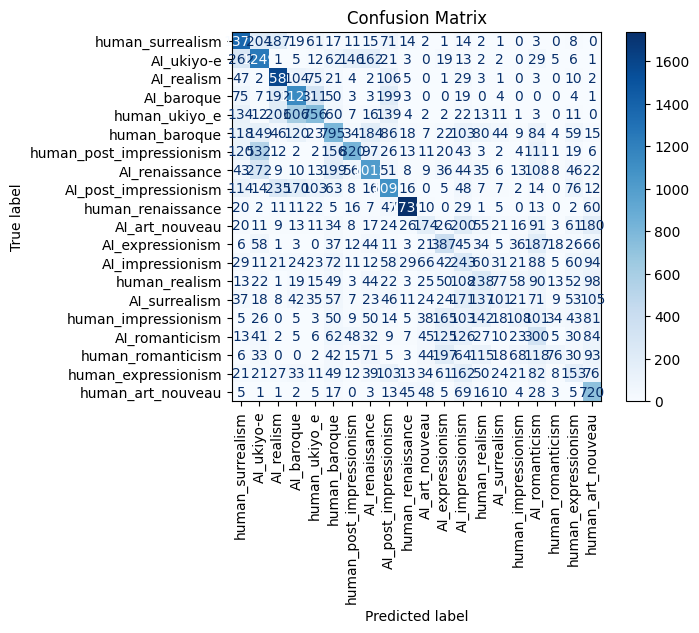


Classification Report:
                          precision    recall  f1-score   support

        human_surrealism       0.56      0.69      0.61      2000
              AI_ukiyo-e       0.47      0.62      0.53      2000
              AI_realism       0.62      0.79      0.70      2000
              AI_baroque       0.49      0.56      0.52      2000
           human_ukiyo_e       0.51      0.38      0.43      2000
           human_baroque       0.42      0.40      0.41      2000
human_post_impressionism       0.67      0.41      0.51      2000
          AI_renaissance       0.55      0.51      0.53      2000
   AI_post_impressionism       0.51      0.55      0.53      2000
       human_renaissance       0.88      0.87      0.88      2000
          AI_art_nouveau       0.31      0.17      0.22      1000
        AI_expressionism       0.33      0.39      0.35      1000
        AI_impressionism       0.15      0.24      0.18      1000
           human_realism       0.23      0.24      

In [6]:
# Analyze test results
metrics = analyze_test_results(
    test_loss=test_loss,
    test_accuracy=test_accuracy,
    test_per_class_accuracy=test_per_class_accuracy,
    all_labels=all_labels,
    all_predictions=all_predictions,
    classes=test_classes
)


In [8]:
metrics['confusion_matrix']

array([[1370,  204,  187,   19,   61,   17,   11,   15,   71,   14,    2,
           1,   14,    2,    1,    0,    3,    0,    8,    0],
       [ 262, 1249,    1,    5,   12,   62,  146,  162,   21,    3,    0,
          19,   13,    2,    2,    0,   29,    5,    6,    1],
       [  47,    2, 1585,  104,   75,   21,    4,    2,  106,    5,    0,
           1,   29,    3,    1,    0,    3,    0,   10,    2],
       [  75,    7,  192, 1129,  311,   50,    3,    3,  199,    3,    0,
           0,   19,    0,    4,    0,    0,    0,    4,    1],
       [ 134,   12,  201,  606,  756,   60,    7,   16,  139,    4,    2,
           2,   22,   13,   11,    1,    3,    0,   11,    0],
       [ 118,  149,   46,  120,   23,  795,   34,  184,   86,   18,    7,
          22,  103,   80,   44,    9,   84,    4,   59,   15],
       [ 120,  532,   12,    2,    2,  156,  820,   97,   26,   13,   11,
          20,   43,    3,    2,    4,  111,    1,   19,    6],
       [  43,  272,    9,   10,   13,  19